This notebook presents statistics of the book data integration.

## Setup


In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(arrow, warn.conflicts=FALSE)
library(jsonlite)

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”


Warning message:
“package ‘stringr’ was built under R version 4.3.2”


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Warning message:
“package ‘arrow’ was built under R version 4.3.2”



Attaching package: ‘jsonlite’




The following object is masked from ‘package:purrr’:

    flatten




I want to use `theme_minimal()` by default:


In [2]:
theme_set(theme_minimal())

And default image sizes aren't great:


In [3]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of the integration.  Let's load those:


In [4]:
link_stats = read_csv("book-links/gender-stats.csv")
glimpse(link_stats)

Rows: 32 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, gender
dbl (2): n_books, n_actions



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 32
Columns: 4
$ dataset   <chr> "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-…
$ gender    <chr> "female", "no-book-author", "no-author-rec", "male", "ambigu…
$ n_books   <dbl> 736825, 598118, 305932, 2414561, 73411, 1102373, 866957, 242…
$ n_actions <dbl> NA, NA, NA, NA, NA, NA, 3852790, 909797, 1115464, 7090496, 4…


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:


In [5]:
link_codes = c('female', 'male', 'ambiguous', 'unknown')

We want the unlink codes in order, so the last is the first link failure:


In [6]:
unlink_codes = c('no-author-rec', 'no-book-author', 'no-book')

In [7]:
all_codes = c(link_codes, unlink_codes)

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.


In [8]:
book_counts = link_stats %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_books) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(book_counts)

Rows: 5
Columns: 9
$ dataset          <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ female           <dbl> 736825, 247131, 314233, 225786, 223527
$ `no-book-author` <dbl> 598118, 166954, 151433, 746315, 734560
$ `no-author-rec`  <dbl> 305932, 157140, 243065, 62332, 61224
$ male             <dbl> 2414561, 550289, 669333, 338392, 334124
$ ambiguous        <dbl> 73411, 24293, 28300, 19115, 18917
$ unknown          <dbl> 1102373, 244288, 309432, 113312, 111379
$ `no-book`        <dbl> 0, 866957, 1138027, 0, 0
$ total            <dbl> 5231220, 2257052, 2853823, 1505252, 1483731


In [9]:
act_counts = link_stats %>%
    filter(dataset != "LOC-MDS") %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_actions) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(act_counts)

Rows: 4
Columns: 9
$ dataset          <chr> "AZ14", "AZ18", "GR-I", "GR-E"
$ `no-book`        <dbl> 3852790, 9908335, 0, 0
$ ambiguous        <dbl> 909797, 2005910, 23242103, 14015868
$ `no-author-rec`  <dbl> 1115464, 3347274, 3541627, 1031982
$ male             <dbl> 7090496, 15541958, 69838115, 33133627
$ female           <dbl> 4905977, 12113491, 81501002, 35570655
$ `no-book-author` <dbl> 2329752, 2758328, 29517391, 11094188
$ unknown          <dbl> 2222075, 4980474, 10844936, 3717539
$ total            <dbl> 22426351, 50655770, 218485174, 98563859


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:


In [10]:
fractionalize = function(data, columns, unlinked=NULL) {
    fracs = select(data, dataset | all_of(columns))
    if (!is.null(unlinked)) {
        fracs = mutate(fracs, unlinked=rowSums(select(data, all_of(unlinked))))
    }
    totals = rowSums(select(fracs, !dataset))
    fracs %>% mutate(across(!dataset, ~ .x / totals))
}
fractionalize(book_counts, link_codes) %>% glimpse()

Rows: 5
Columns: 5
$ dataset   <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ female    <dbl> 0.1702787, 0.2318300, 0.2378214, 0.3241234, 0.3249189
$ male      <dbl> 0.5580000, 0.5162181, 0.5065723, 0.4857731, 0.4856828
$ ambiguous <dbl> 0.01696513, 0.02278891, 0.02141833, 0.02744023, 0.02749776
$ unknown   <dbl> 0.2547561, 0.2291630, 0.2341879, 0.1626632, 0.1619006


And a helper function for plotting bar charts:


In [11]:
plot_bars = function(data, what="UNSPECIFIED") {
    tall = data %>%
        pivot_longer(!dataset, names_to="status", values_to="fraction")
    codes = c(all_codes, "unlinked")
    codes = intersect(codes, unique(tall$status))
    tall = tall %>% mutate(status=ordered(status, codes))
    ggplot(tall) +
        aes(y=dataset, x=fraction, fill=status) +
        geom_col(position=position_stack(reverse=TRUE), width=0.5) +
        geom_text(aes(label=if_else(fraction >= 0.1,
                                    sprintf("%.1f%%", fraction * 100),
                                    "")),
                  position=position_stack(reverse=TRUE, vjust=0.5),
                  colour="white", fontface="bold") +
        scale_fill_brewer(type="qual", palette="Dark2") +
        ylab("Dataset") +
        xlab(paste("Fraction of", what)) +
        labs(fill="Author Gender")
}

## Resolution of Books

What fraction of *unique books* are resolved from each source?


In [12]:
book_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.1408515,0.4615675,0.014033247,0.21072962,0.05848196,0.11433624,0.0000000
AZ14,0.1094928,0.2438087,0.010763155,0.10823322,0.06962179,0.07396994,0.3841103
AZ18,0.1101095,0.2345391,0.009916523,0.10842719,0.08517172,0.05306321,0.3987728
GR-I,0.1499988,0.2248075,0.012698870,0.07527776,0.04140968,0.49580735,0.0000000
GR-E,0.1506520,0.2251918,0.012749616,0.07506684,0.04126354,0.49507626,0.0000000


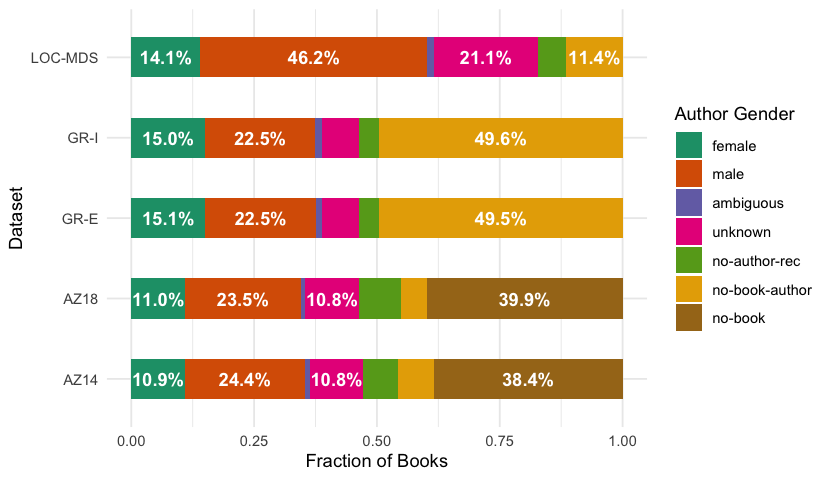

In [13]:
book_counts %>% fractionalize(all_codes) %>% plot_bars("Books")

In [14]:
book_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.1408515,0.4615675,0.014033247,0.21072962,0.1728182
AZ14,0.1094928,0.2438087,0.010763155,0.10823322,0.5277021
AZ18,0.1101095,0.2345391,0.009916523,0.10842719,0.5370077
GR-I,0.1499988,0.2248075,0.012698870,0.07527776,0.5372170
GR-E,0.1506520,0.2251918,0.012749616,0.07506684,0.5363398


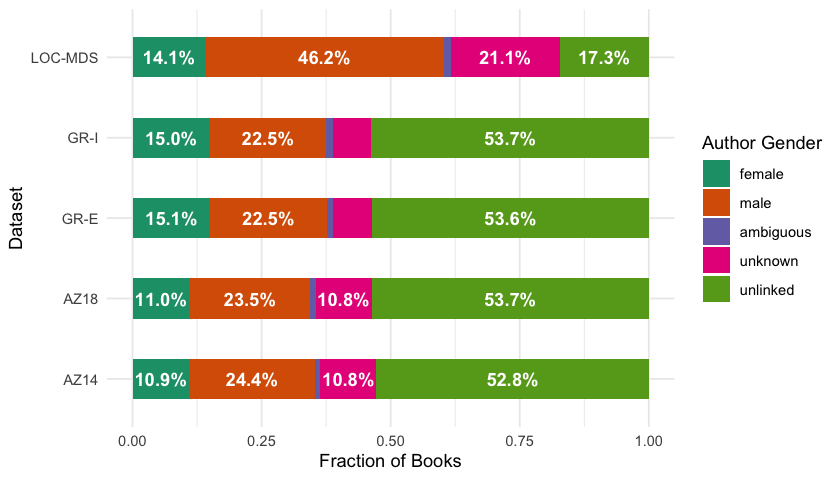

In [15]:
book_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Books")

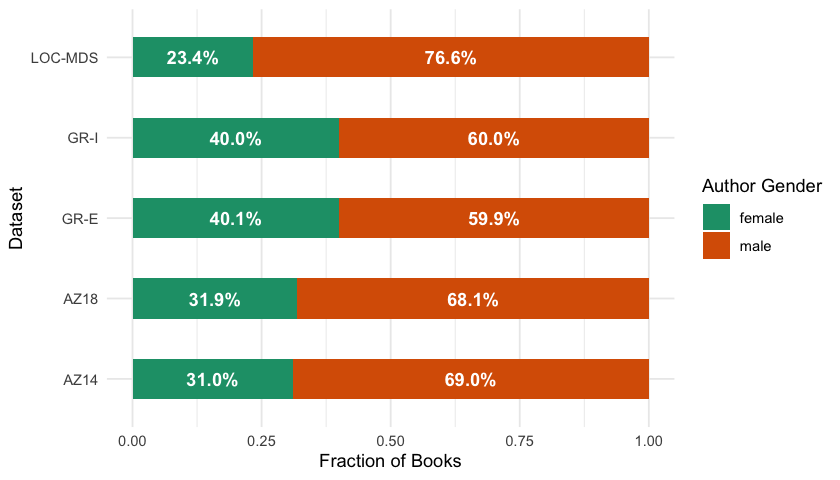

In [16]:
book_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Books")

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?


In [17]:
act_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AZ14,0.2187595,0.3161681,0.04056821,0.09908322,0.04973899,0.1038846,0.1717975
AZ18,0.2391335,0.3068152,0.03959885,0.09831997,0.06607883,0.0544524,0.1956013
GR-I,0.3730276,0.3196469,0.10637840,0.04963694,0.01620992,0.1351002,0.0000000
GR-E,0.3608894,0.3361641,0.14220089,0.03771706,0.01047019,0.1125584,0.0000000


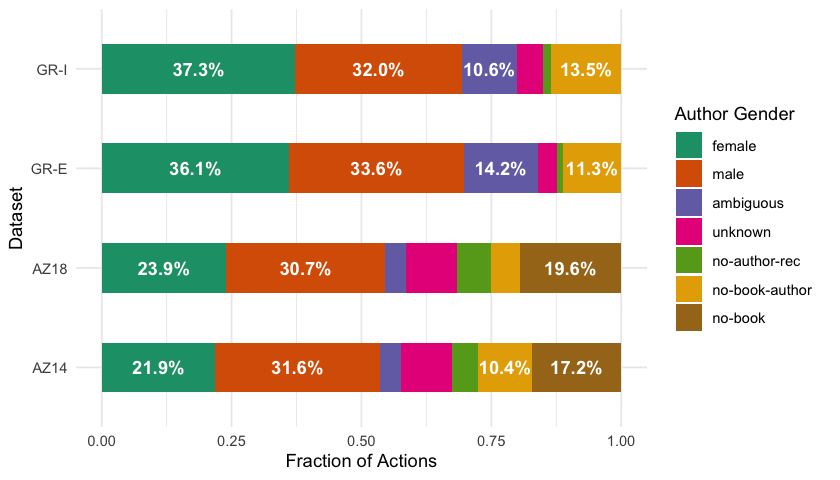

In [18]:
act_counts %>% fractionalize(all_codes) %>% plot_bars("Actions")

In [19]:
act_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AZ14,0.2187595,0.3161681,0.04056821,0.09908322,0.3254210
AZ18,0.2391335,0.3068152,0.03959885,0.09831997,0.3161325
GR-I,0.3730276,0.3196469,0.10637840,0.04963694,0.1513101
GR-E,0.3608894,0.3361641,0.14220089,0.03771706,0.1230286


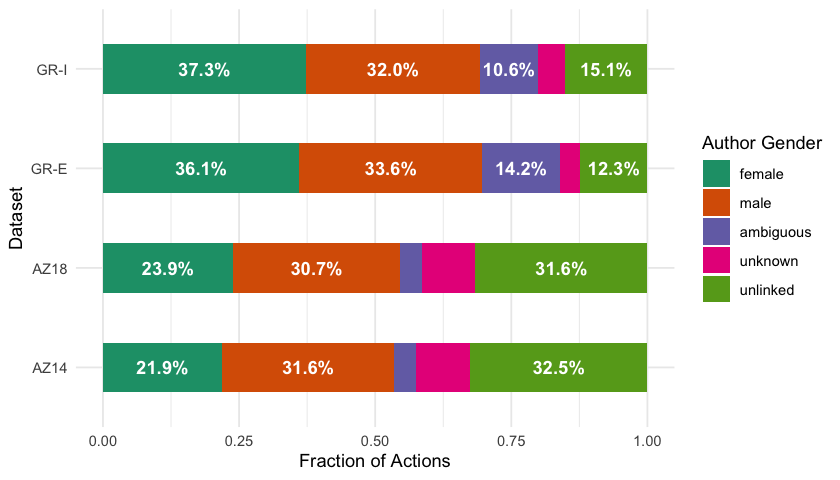

In [20]:
act_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Actions")

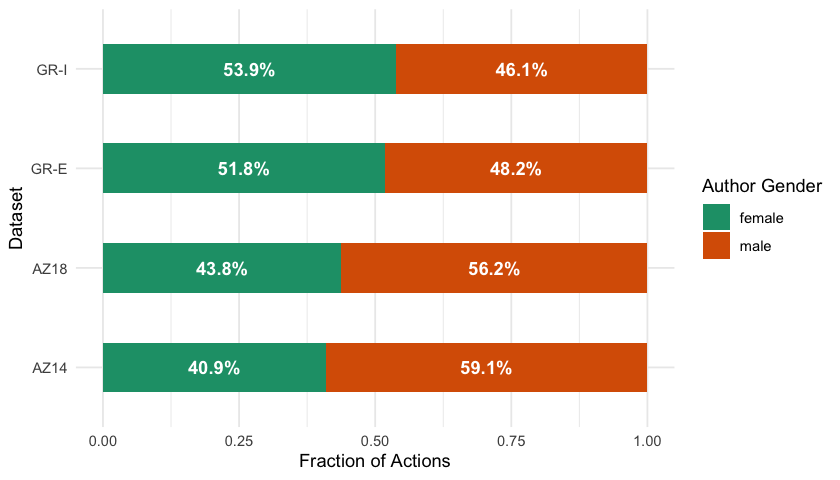

In [21]:
act_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Actions")

## Metrics

Finally, we're going to write coverage metrics.


In [22]:
book_linked = eval(quote(male + female + ambiguous), envir=book_counts)
book_coverage = book_linked / book_counts$total
book_coverage = setNames(book_coverage, book_counts$dataset)
book_coverage

LOC-MDS      AZ14      AZ18      GR-I      GR-E 
0.6164522 0.3640647 0.3545651 0.3875052 0.3885934

In [23]:
json = toJSON(
    as.list(book_coverage),
    auto_unbox=TRUE,
)
write_file(json, "book-coverage.json")